# 1.21c: Per-Token Divergence Analysis

**Goal:** Track how individual dead tokens diverge between Flannel 1 (tied weights) and Flannel 2 (untied weights).

## The Question

We know from 1.21a that dead tokens collectively diverge (Frobenius norm grows over time). But:
- **Which specific tokens diverge most?**
- **When do they diverge?**
- **Is divergence uniform across all dead tokens, or concentrated in a few outliers?**

## Per-Token Divergence

For each dead token $i$ at timestep $t$, compute:

$$\delta_i(t) = \|W_{1,i}(t) - W_{2,i}(t)\|_2$$

This measures the Euclidean distance between token $i$'s position in Flannel 1 vs Flannel 2.

## Analyses

1. **Ranking:** Which tokens diverge most? (sort by $\delta_i(1000)$)
2. **Trajectories:** Plot $\delta_i(t)$ over time for top divergers
3. **Heatmap:** Token × time visualization of divergence
4. **Distribution:** Histogram of final divergences
5. **Statistics:** Mean, std, outliers

## Parameters

In [1]:
# Data paths
FLANNEL_1_PATH = '../tensors/Flannel/1.20a_flannel_1.safetensors'
FLANNEL_2_PATH = '../tensors/Flannel/1.20b_flannel_2.safetensors'
TOKEN_MASKS_PATH = '../tensors/Flannel/live_dead_tokens.safetensors'

# Analysis parameters
N_TOP_DIVERGERS = 20  # How many top diverging tokens to plot

# Visualization
PLOT_DPI = 150
COLORMAP = 'inferno'
ALPHA = 0.6
LINEWIDTH = 1.5

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading data...\n")

# Flannel 1
data_1 = load_file(FLANNEL_1_PATH)
W_1 = data_1['embeddings'].to(torch.float32).to(device)

# Flannel 2
data_2 = load_file(FLANNEL_2_PATH)
W_2 = data_2['embeddings_W'].to(torch.float32).to(device)

# Token masks
masks = load_file(TOKEN_MASKS_PATH)
dead_mask = masks['dead_mask'].to(device)
dead_indices = masks['dead_indices'].to(device)

n_steps, vocab_size, hidden_dim = W_1.shape
n_dead = dead_mask.sum().item()

print(f"✓ Data loaded")
print(f"  Shape: {W_1.shape}")
print(f"  Dead tokens: {n_dead}")
print(f"  Device: {device}")

Loading data...

✓ Data loaded
  Shape: torch.Size([1001, 10000, 64])
  Dead tokens: 3699
  Device: mps


## Compute Per-Token Divergence

For each dead token at each timestep: $\delta_i(t) = \|W_{1,i}(t) - W_{2,i}(t)\|_2$

In [5]:
print("\nComputing per-token divergence...\n")

# Extract dead token embeddings
W_1_dead = W_1[:, dead_mask, :]  # (n_steps, n_dead, hidden_dim)
W_2_dead = W_2[:, dead_mask, :]

# Compute difference vectors
diff = W_1_dead - W_2_dead  # (n_steps, n_dead, hidden_dim)

# Compute L2 norm of difference for each token at each timestep
delta = torch.norm(diff, p=2, dim=2)  # (n_steps, n_dead)

print(f"✓ Computed divergence")
print(f"  Shape: {delta.shape}")
print(f"  Mean final divergence: {delta[-1].mean().item():.6f}")
print(f"  Max final divergence: {delta[-1].max().item():.6f}")
print(f"  Min final divergence: {delta[-1].min().item():.6f}")


Computing per-token divergence...

✓ Computed divergence
  Shape: torch.Size([1001, 3699])
  Mean final divergence: 0.295281
  Max final divergence: 0.344194
  Min final divergence: 0.283467


## Rank Tokens by Final Divergence

In [6]:
print("\nRanking tokens by final divergence...\n")

# Final divergence for each token
final_divergence = delta[-1]  # (n_dead,)

# Sort by divergence (descending)
sorted_indices = torch.argsort(final_divergence, descending=True)
sorted_divergence = final_divergence[sorted_indices]

# Get original token IDs for top divergers
top_token_ids = dead_indices[sorted_indices[:N_TOP_DIVERGERS]]

print(f"Top {N_TOP_DIVERGERS} diverging dead tokens:")
print()
for rank, (idx, div) in enumerate(zip(top_token_ids.cpu().numpy(), 
                                        sorted_divergence[:N_TOP_DIVERGERS].cpu().numpy()), 1):
    print(f"  {rank:2d}. Token {idx:5d}: δ = {div:.6f}")

print(f"\nBottom {N_TOP_DIVERGERS} (least diverging):")
print()
bottom_token_ids = dead_indices[sorted_indices[-N_TOP_DIVERGERS:]]
for rank, (idx, div) in enumerate(zip(bottom_token_ids.cpu().numpy(), 
                                        sorted_divergence[-N_TOP_DIVERGERS:].cpu().numpy()), 1):
    print(f"  {rank:2d}. Token {idx:5d}: δ = {div:.6f}")


Ranking tokens by final divergence...

Top 20 diverging dead tokens:

   1. Token   994: δ = 0.344194
   2. Token  8302: δ = 0.337677
   3. Token  1843: δ = 0.336747
   4. Token  9101: δ = 0.335334
   5. Token   984: δ = 0.333209
   6. Token  1929: δ = 0.329599
   7. Token   447: δ = 0.329022
   8. Token  2080: δ = 0.324371
   9. Token   810: δ = 0.323619
  10. Token   983: δ = 0.323278
  11. Token  1931: δ = 0.323206
  12. Token  1587: δ = 0.323146
  13. Token   982: δ = 0.322822
  14. Token  2522: δ = 0.322064
  15. Token  2149: δ = 0.321682
  16. Token  5899: δ = 0.320363
  17. Token  7383: δ = 0.320076
  18. Token  2116: δ = 0.319589
  19. Token  5174: δ = 0.318695
  20. Token   683: δ = 0.318412

Bottom 20 (least diverging):

   1. Token  2171: δ = 0.285784
   2. Token  1708: δ = 0.285784
   3. Token  1793: δ = 0.285779
   4. Token  7519: δ = 0.285702
   5. Token  5567: δ = 0.285658
   6. Token   631: δ = 0.285594
   7. Token  1281: δ = 0.285509
   8. Token  1590: δ = 0.285492
  

## Plot: Top Diverger Trajectories

Show $\delta_i(t)$ over time for the tokens that diverge most.


Plotting top 20 diverger trajectories...



/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_72625/1610041772.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap(COLORMAP)(i / N_TOP_DIVERGERS)


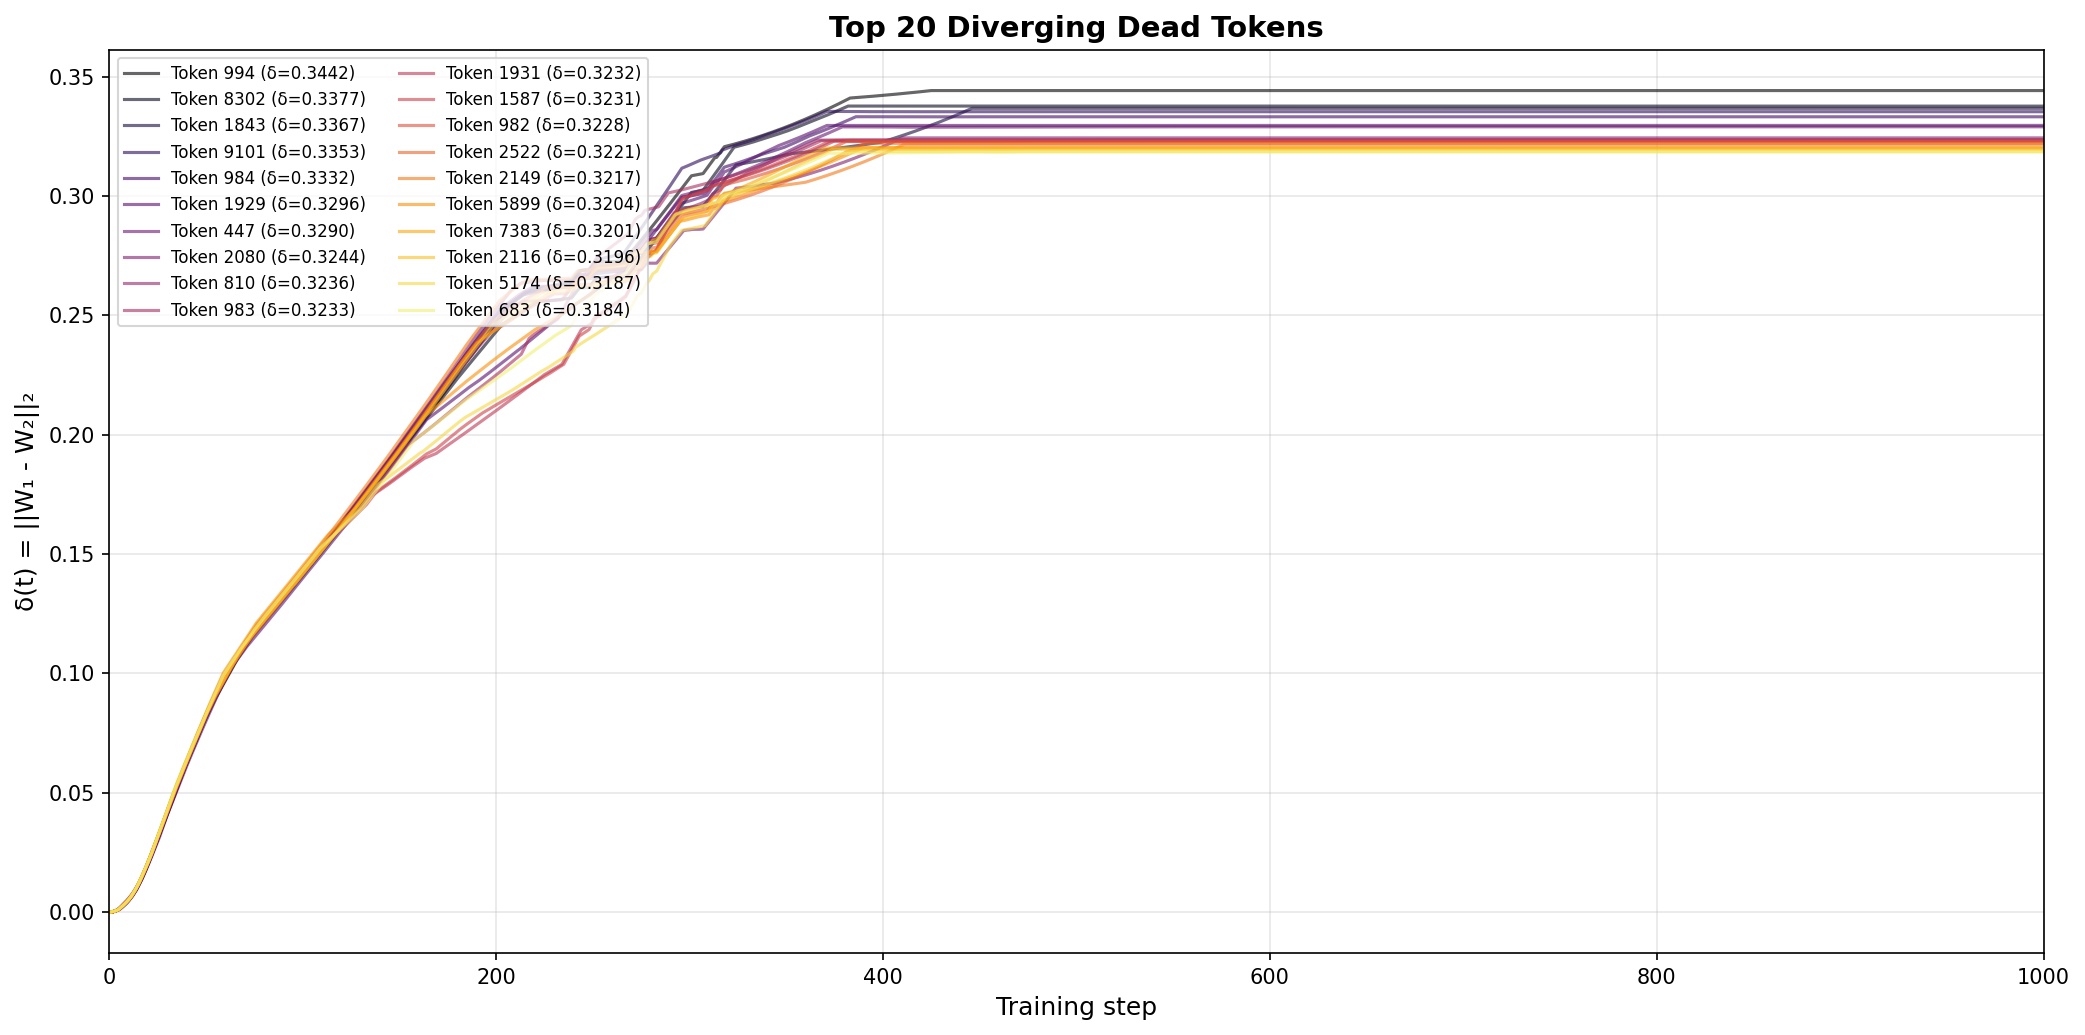

✓ Trajectory plot complete


In [7]:
print(f"\nPlotting top {N_TOP_DIVERGERS} diverger trajectories...\n")

fig, ax = plt.subplots(figsize=(14, 7), dpi=PLOT_DPI)

timesteps = np.arange(n_steps)
delta_cpu = delta.cpu().numpy()

# Plot top divergers
for i, token_idx in enumerate(sorted_indices[:N_TOP_DIVERGERS]):
    original_id = dead_indices[token_idx].item()
    trajectory = delta_cpu[:, token_idx]
    
    # Color by rank (red = highest divergence)
    color = plt.cm.get_cmap(COLORMAP)(i / N_TOP_DIVERGERS)
    
    ax.plot(timesteps, trajectory, 
            color=color, alpha=ALPHA, linewidth=LINEWIDTH,
            label=f'Token {original_id} (δ={trajectory[-1]:.4f})')

ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('δ(t) = ||W₁ - W₂||₂', fontsize=12)
ax.set_title(f'Top {N_TOP_DIVERGERS} Diverging Dead Tokens', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, n_steps-1)
ax.legend(loc='upper left', fontsize=8, ncol=2)

plt.tight_layout()
plt.show()

print("✓ Trajectory plot complete")

## Plot: Heatmap (Token × Time)

Visualize all dead tokens' divergence over time.

- **Y-axis:** Token ID (sorted by final divergence, descending)
- **X-axis:** Training step
- **Color:** Divergence magnitude


Plotting divergence heatmap...



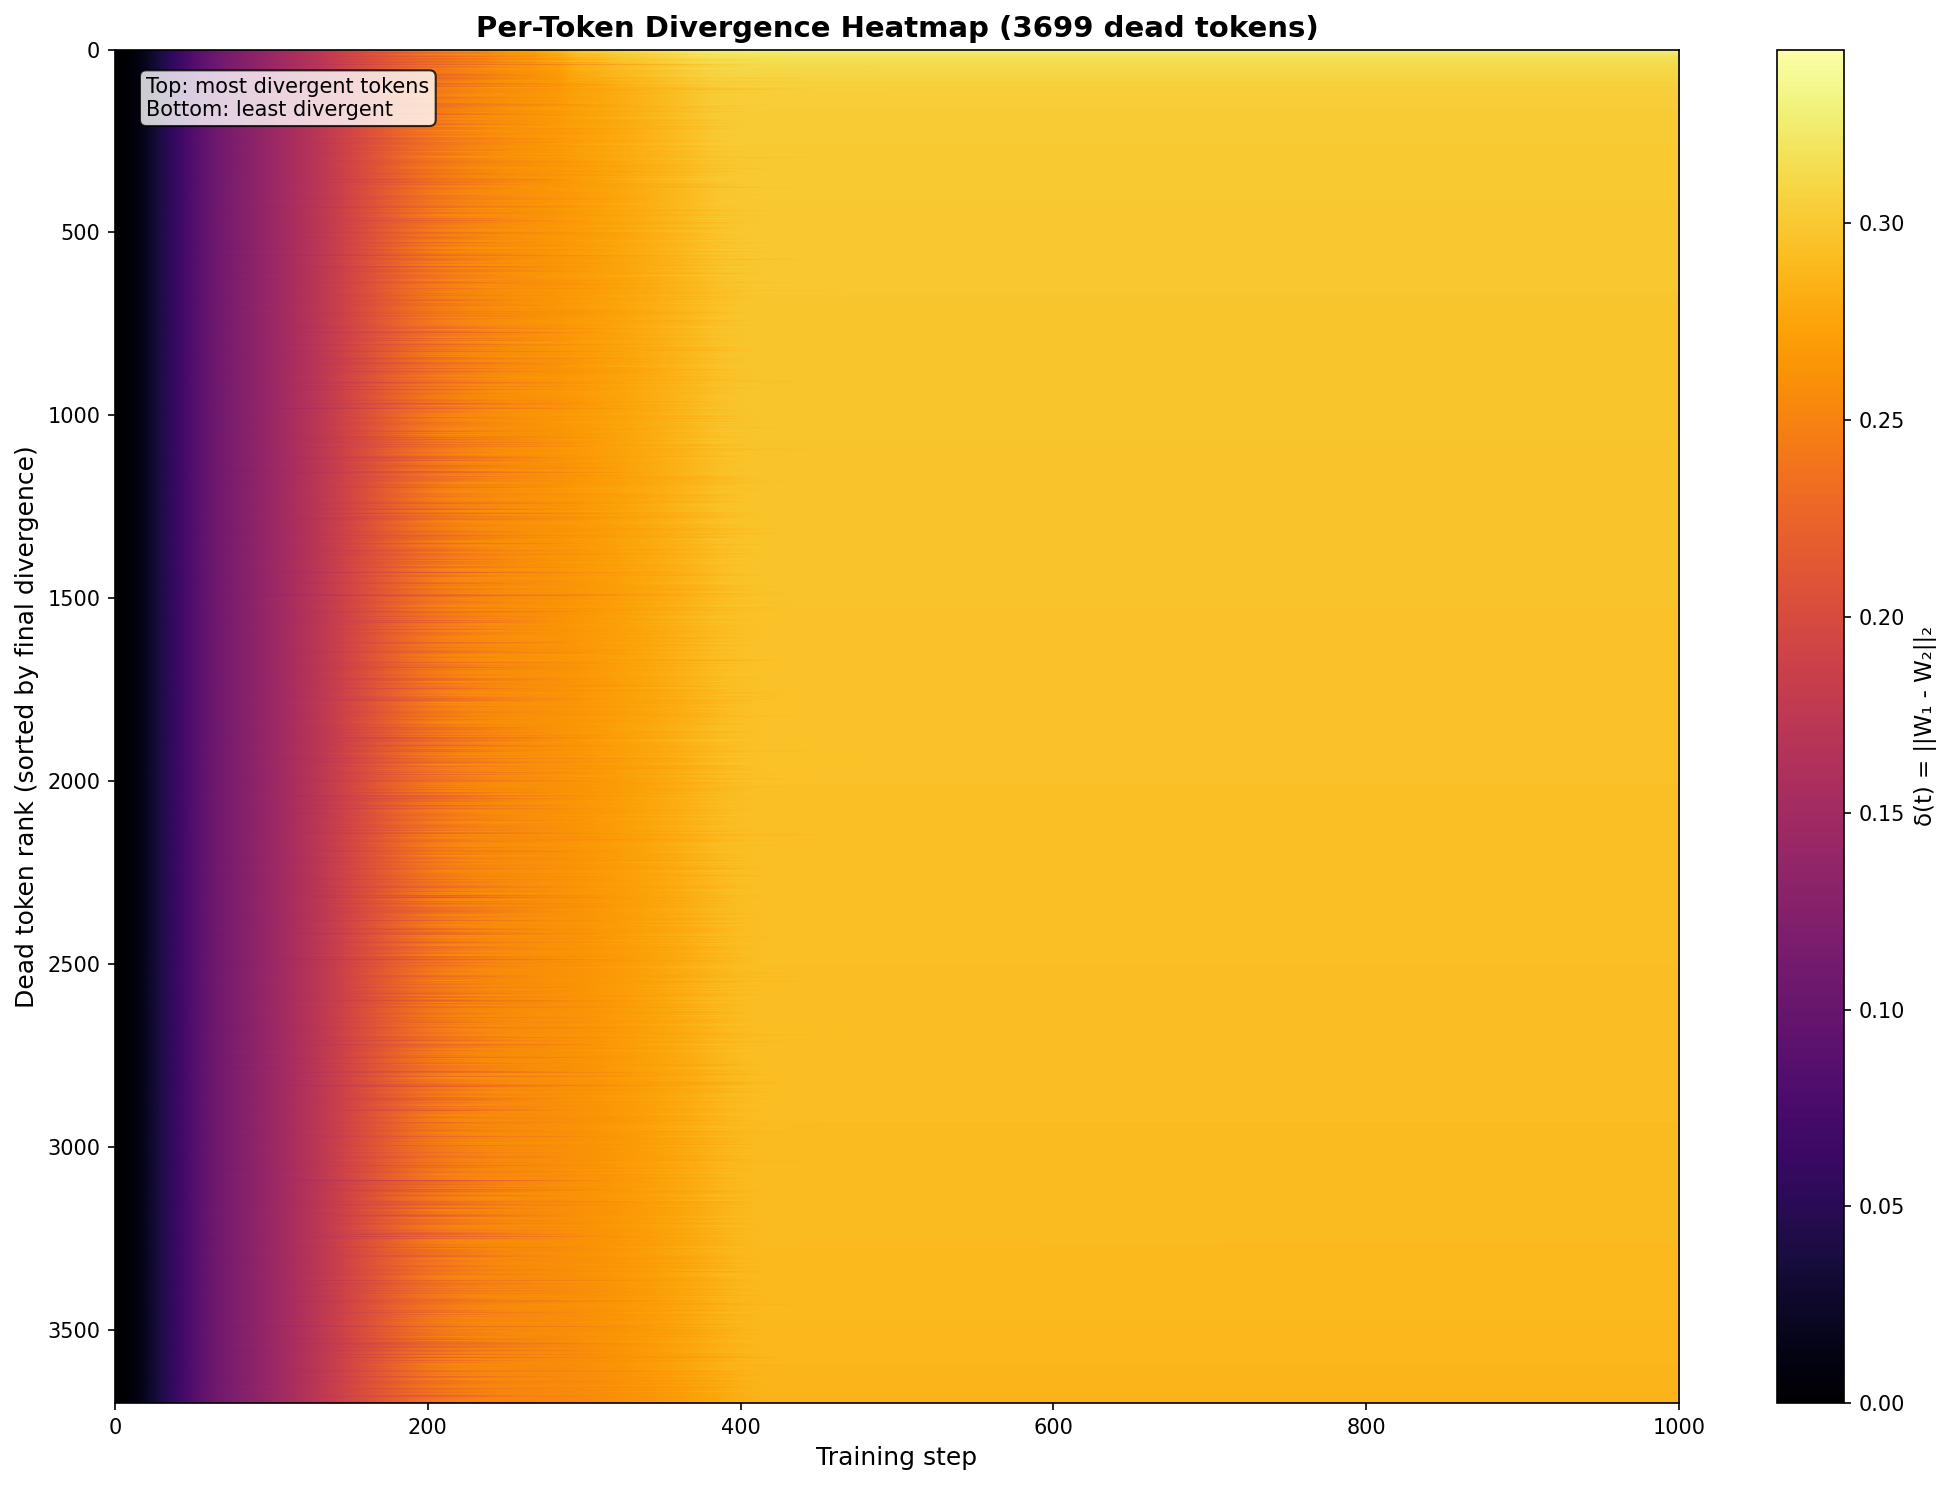

✓ Heatmap complete


In [8]:
print("\nPlotting divergence heatmap...\n")

fig, ax = plt.subplots(figsize=(14, 10), dpi=PLOT_DPI)

# Sort tokens by final divergence for display
delta_sorted = delta[:, sorted_indices].cpu().numpy().T  # (n_dead, n_steps)

# Heatmap
im = ax.imshow(delta_sorted, aspect='auto', cmap=COLORMAP, origin='upper',
               extent=[0, n_steps-1, n_dead, 0])

ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Dead token rank (sorted by final divergence)', fontsize=12)
ax.set_title(f'Per-Token Divergence Heatmap ({n_dead} dead tokens)', fontsize=14, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('δ(t) = ||W₁ - W₂||₂', fontsize=11)

# Annotation
ax.text(0.02, 0.98, 'Top: most divergent tokens\nBottom: least divergent', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("✓ Heatmap complete")

## Plot: Distribution of Final Divergences

How are divergences distributed across all dead tokens?


Plotting distribution of final divergences...



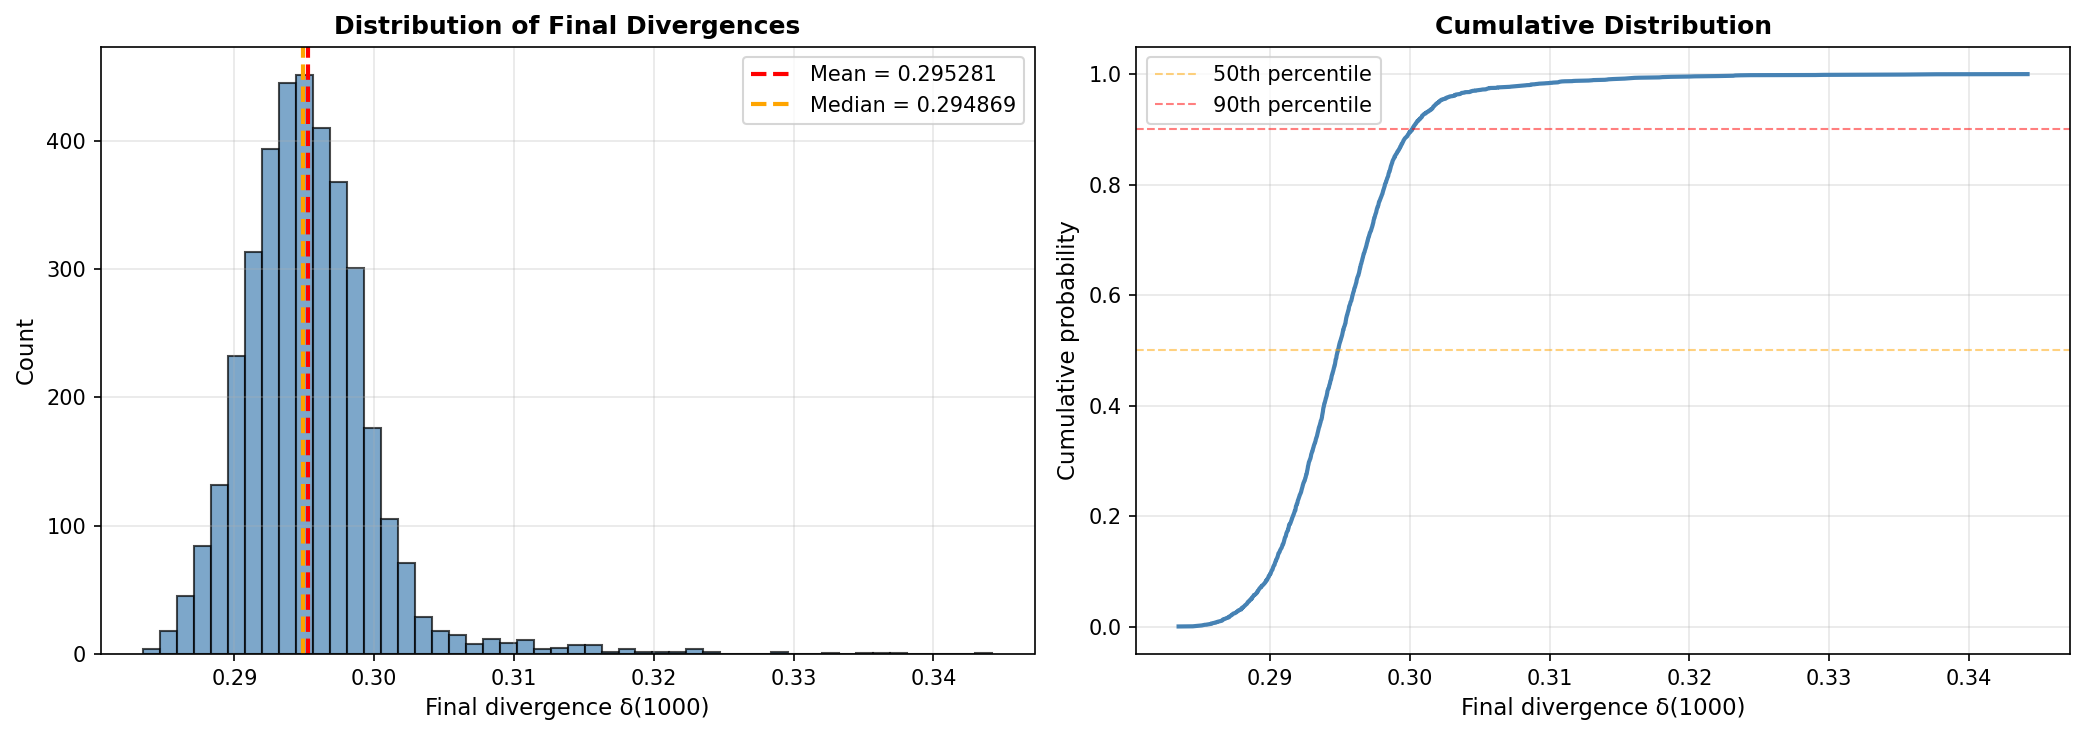

✓ Distribution plots complete


In [9]:
print("\nPlotting distribution of final divergences...\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=PLOT_DPI)

final_div_cpu = final_divergence.cpu().numpy()

# Histogram
ax1.hist(final_div_cpu, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(final_div_cpu.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean = {final_div_cpu.mean():.6f}')
ax1.axvline(np.median(final_div_cpu), color='orange', linestyle='--', linewidth=2,
            label=f'Median = {np.median(final_div_cpu):.6f}')
ax1.set_xlabel('Final divergence δ(1000)', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Distribution of Final Divergences', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Cumulative distribution
sorted_final = np.sort(final_div_cpu)
cumulative = np.arange(1, len(sorted_final) + 1) / len(sorted_final)

ax2.plot(sorted_final, cumulative, linewidth=2, color='steelblue')
ax2.axhline(0.5, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='50th percentile')
ax2.axhline(0.9, color='red', linestyle='--', linewidth=1, alpha=0.5, label='90th percentile')
ax2.set_xlabel('Final divergence δ(1000)', fontsize=11)
ax2.set_ylabel('Cumulative probability', fontsize=11)
ax2.set_title('Cumulative Distribution', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print("✓ Distribution plots complete")

## Statistics

In [10]:
print("\n" + "="*80)
print("PER-TOKEN DIVERGENCE STATISTICS")
print("="*80 + "\n")

print(f"Dead tokens: {n_dead}")
print()

print(f"Final divergence δ(1000):")
print(f"  Mean: {final_div_cpu.mean():.6f}")
print(f"  Std: {final_div_cpu.std():.6f}")
print(f"  Median: {np.median(final_div_cpu):.6f}")
print(f"  Range: [{final_div_cpu.min():.6f}, {final_div_cpu.max():.6f}]")
print()

print(f"Percentiles:")
for p in [10, 25, 50, 75, 90, 95, 99]:
    val = np.percentile(final_div_cpu, p)
    print(f"  {p:2d}%: {val:.6f}")
print()

# Coefficient of variation
cv = final_div_cpu.std() / final_div_cpu.mean()
print(f"Coefficient of variation: {cv:.4f}")
print()

# Interpretation
print(f"Interpretation:")
if cv < 0.1:
    print(f"  → Very uniform divergence (CV < 0.1)")
    print(f"  → All dead tokens diverge by similar amounts")
elif cv < 0.3:
    print(f"  → Moderately uniform divergence (CV < 0.3)")
    print(f"  → Most dead tokens behave similarly")
else:
    print(f"  → High variability (CV = {cv:.4f})")
    print(f"  → Some dead tokens diverge much more than others")
    print(f"  → Check heatmap and top divergers for patterns")

print("\n" + "="*80)


PER-TOKEN DIVERGENCE STATISTICS

Dead tokens: 3699

Final divergence δ(1000):
  Mean: 0.295281
  Std: 0.004938
  Median: 0.294869
  Range: [0.283467, 0.344194]

Percentiles:
  10%: 0.290099
  25%: 0.292299
  50%: 0.294869
  75%: 0.297597
  90%: 0.300177
  95%: 0.302098
  99%: 0.314120

Coefficient of variation: 0.0167

Interpretation:
  → Very uniform divergence (CV < 0.1)
  → All dead tokens diverge by similar amounts



## Divergence Velocity (Optional)

How fast are tokens diverging? Compute $v_i(t) = \delta_i(t+1) - \delta_i(t)$

In [11]:
print("\nComputing divergence velocity...\n")

# Velocity (first derivative)
velocity = delta[1:] - delta[:-1]  # (n_steps-1, n_dead)

print(f"✓ Computed velocity")
print(f"  Shape: {velocity.shape}")
print(f"  Mean velocity (all time): {velocity.mean().item():.6e}")
print(f"  Max velocity: {velocity.max().item():.6e}")


Computing divergence velocity...

✓ Computed velocity
  Shape: torch.Size([1000, 3699])
  Mean velocity (all time): 2.952812e-04
  Max velocity: 2.403658e-03



Plotting divergence velocity (top divergers)...



/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_72625/2348251523.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap(COLORMAP)(i / N_TOP_DIVERGERS)


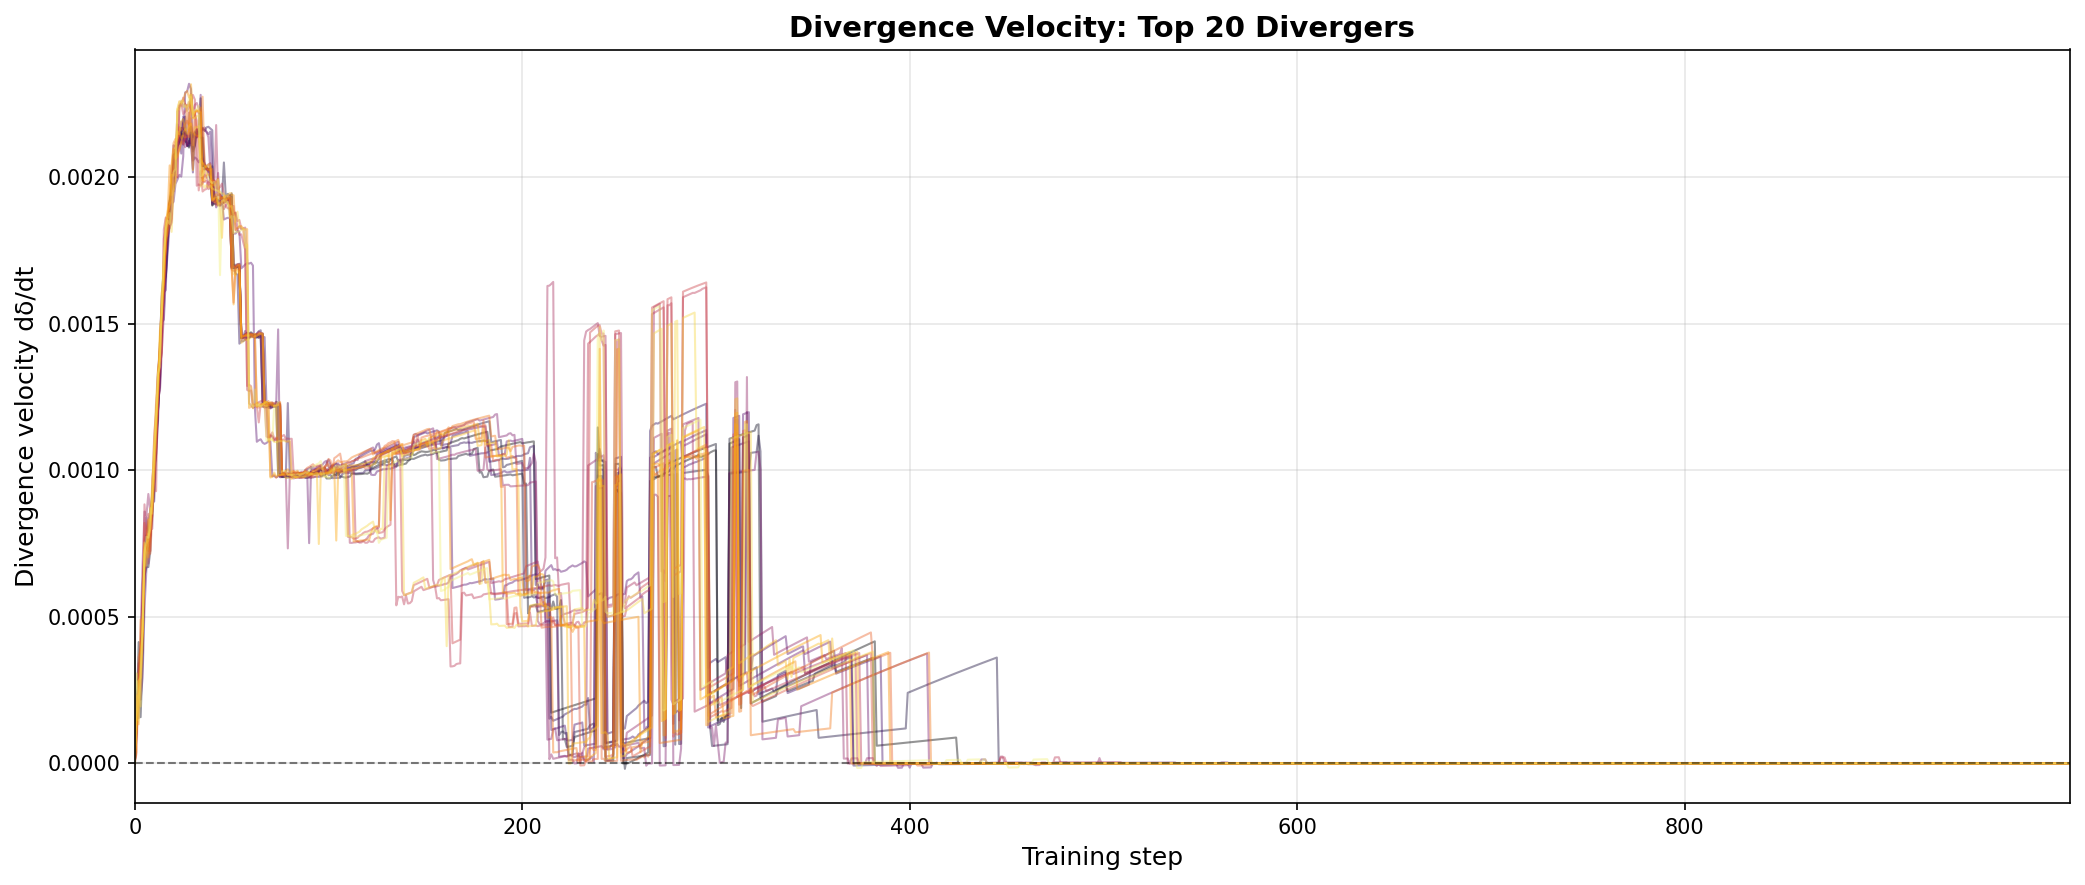

✓ Velocity plot complete


In [12]:
print("\nPlotting divergence velocity (top divergers)...\n")

fig, ax = plt.subplots(figsize=(14, 6), dpi=PLOT_DPI)

velocity_cpu = velocity.cpu().numpy()
timesteps_vel = np.arange(n_steps - 1)

# Plot top divergers' velocities
for i, token_idx in enumerate(sorted_indices[:N_TOP_DIVERGERS]):
    original_id = dead_indices[token_idx].item()
    vel_trajectory = velocity_cpu[:, token_idx]
    
    color = plt.cm.get_cmap(COLORMAP)(i / N_TOP_DIVERGERS)
    
    ax.plot(timesteps_vel, vel_trajectory, 
            color=color, alpha=ALPHA*0.7, linewidth=1,
            label=f'Token {original_id}')

ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Divergence velocity dδ/dt', fontsize=12)
ax.set_title(f'Divergence Velocity: Top {N_TOP_DIVERGERS} Divergers', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, n_steps-2)

plt.tight_layout()
plt.show()

print("✓ Velocity plot complete")

## Summary

In [13]:
print("\n" + "="*80)
print("SUMMARY")
print("="*80 + "\n")

print(f"Analyzed {n_dead} dead tokens over {n_steps} timesteps")
print()
print(f"Key findings:")
print()
print(f"1. Most divergent token: {top_token_ids[0].item()} (δ = {sorted_divergence[0].item():.6f})")
print(f"2. Least divergent token: {bottom_token_ids[0].item()} (δ = {sorted_divergence[-1].item():.6f})")
print(f"3. Divergence ratio (max/min): {(sorted_divergence[0] / sorted_divergence[-1]).item():.2f}×")
print()

# When does divergence happen?
mean_trajectory = delta.mean(dim=1).cpu().numpy()
half_max = mean_trajectory[-1] / 2
half_max_step = np.argmax(mean_trajectory >= half_max)

print(f"4. Half-max divergence reached at step: {half_max_step}")
print(f"   (50% of final divergence happens by step {half_max_step})")
print()

print(f"5. Divergence uniformity: CV = {cv:.4f}")
if cv < 0.3:
    print(f"   → Dead tokens diverge relatively uniformly")
else:
    print(f"   → Significant variation; some tokens diverge much more than others")

print("\n" + "="*80)


SUMMARY

Analyzed 3699 dead tokens over 1001 timesteps

Key findings:

1. Most divergent token: 994 (δ = 0.344194)
2. Least divergent token: 2171 (δ = 0.283467)
3. Divergence ratio (max/min): 1.21×

4. Half-max divergence reached at step: 105
   (50% of final divergence happens by step 105)

5. Divergence uniformity: CV = 0.0167
   → Dead tokens diverge relatively uniformly

